# 💳 Credit Card Fraud Detection Intuitions

## What is Credit Card Fraud?
Credit card fraud is when someone uses another person's credit card or account information to make unauthorized purchases or access funds through cash advances. Credit card fraud doesn’t just happen online; it happens in brick-and-mortar stores, too. As a business owner, you can avoid serious headaches – and unwanted publicity – by recognizing potentially fraudulent use of credit cards in your payment environment.

## Three challenges surrounding credit card fraud

1. It's not always easy to agree on ground truth for what "fraud" means.
2. Regardless of how you define ground truth, the vast majority of charges are not fraudulent.
3. Most merchants aren't experts at evaluating the business impact of fraud.

## Problem Statement:

The Credit Card Fraud Detection Problem includes modeling past credit card transactions with the knowledge of the ones that turned out to be a fraud. This model is then used to identify whether a new transaction is fraudulent or not. Our aim here is to detect 100% of the fraudulent transactions while minimizing the incorrect fraud classifications.


## Observations
- Very few transactions are actually fraudulent (less than 1%). The data set is highly skewed, consisting of `492` frauds in a total of `284,807` observations. This resulted in only `0.172%` fraud cases. This skewed set is justified by the low number of fraudulent transactions.
- The dataset consists of numerical values from the `28` ‘Principal Component Analysis (PCA)’ transformed features, namely V1 to V28. Furthermore, there is no metadata about the original features provided, so pre-analysis or feature study could not be done.
- The ‘Time’ and ‘Amount’ features are not transformed data.
- There is no missing value in the dataset.

## Why does class imbalanced affect model performance?

- In general, we want to maximize the recall while capping FPR (False Positive Rate), but you can classify a lot of charges wrong and still maintain a low FPR because you have a large number of true negatives.
- This is conducive to picking a relatively low threshold, which results in the high recall but extremely low precision.

## What is the catch?
- Training a model on a balanced dataset optimizes performance on validation data.
- However, the goal is to optimize performance on the imbalanced production dataset. You ultimately need to find a balance that works best in production.
- One solution to this problem is: Use all fraudulent transactions, but subsample non-fraudulent transactions as needed to hit our target rate.

## Business questions to brainstorm:
Since all features are anonymous, we will focus our analysis on non-anonymized features: `Time`, `Amount`
1. How different is the amount of money used in different transaction classes?
2. Do fraudulent transactions occur more often during a certain frames?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

In [2]:
data = pd.read_csv("/content/creditcard.csv")
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# 🔍 Exploratory Data Analysis


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
pd.set_option("display.float", "{:.2f}".format)
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,...,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


Let us now check the missing values in the dataset

In [5]:
data.isnull().sum().sum()

0

In [6]:
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

### The only non-transformed variables to work with are:
- `Time`
- `Amount`
- `Class` (1: fraud, 0: not_fraud)

<ipython-input-7-71e2bfb750ad>:3: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  count_classes = pd.value_counts(data['Class'], sort = True)


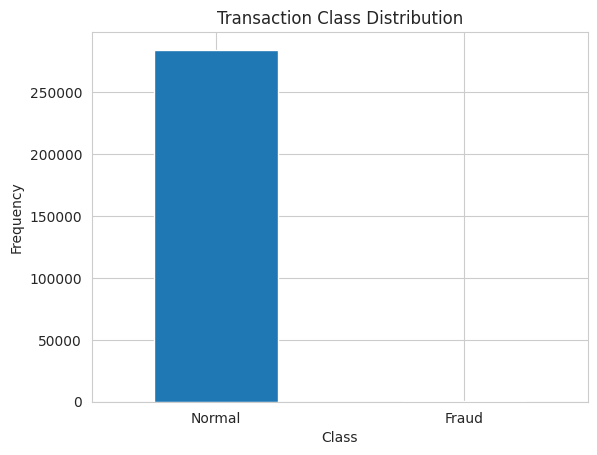

In [7]:
LABELS = ["Normal", "Fraud"]

count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [8]:
data.Class.value_counts()

,count
Class,
0,284315
1,492


Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

Determine the number of fraud and valid transactions in the entire dataset.

In [9]:
fraud = data[data['Class']==1]
normal = data[data['Class']==0]

print(f"Shape of Fraudulant transactions: {fraud.shape}")
print(f"Shape of Non-Fraudulant transactions: {normal.shape}")

Shape of Fraudulant transactions: (492, 31)
Shape of Non-Fraudulant transactions: (284315, 31)


How different are the amount of money used in different transaction classes?

In [10]:
pd.concat([fraud.Amount.describe(), normal.Amount.describe()], axis=1)

,Amount,Amount
count,492.00,284315.00
mean,122.21,88.29
std,256.68,250.11
min,0.00,0.00
25%,1.00,5.65
50%,9.25,22.00
75%,105.89,77.05
max,2125.87,25691.16


Do fraudulent transactions occur more often during certain time frame ?

In [11]:
pd.concat([fraud.Time.describe(), normal.Time.describe()], axis=1)

,Time,Time
count,492.00,284315.00
mean,80746.81,94838.20
std,47835.37,47484.02
min,406.00,0.00
25%,41241.50,54230.00
50%,75568.50,84711.00
75%,128483.00,139333.00
max,170348.00,172792.00


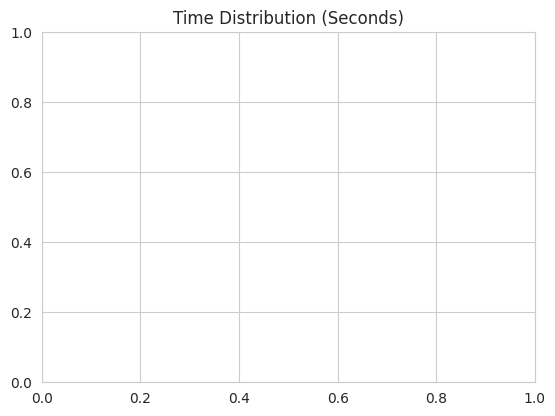

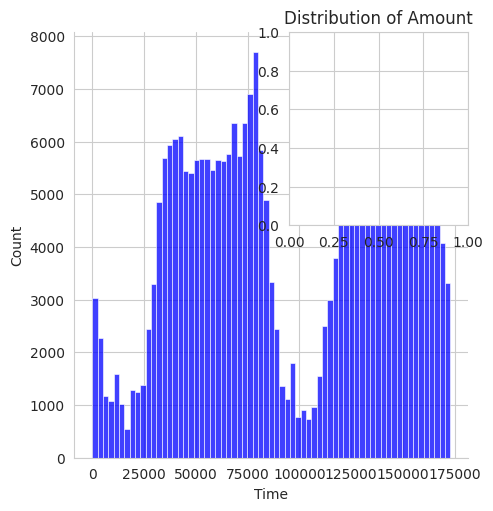

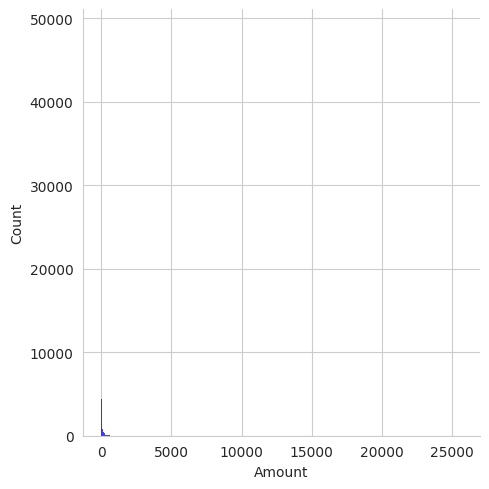

In [12]:
# plot the time feature
plt.figure(figsize=(14,10))

plt.subplot(2, 2, 1)
plt.title('Time Distribution (Seconds)')

sns.displot(data['Time'], color='blue');

#plot the amount feature
plt.subplot(2, 2, 2)
plt.title('Distribution of Amount')
sns.displot(data['Amount'],color='blue');

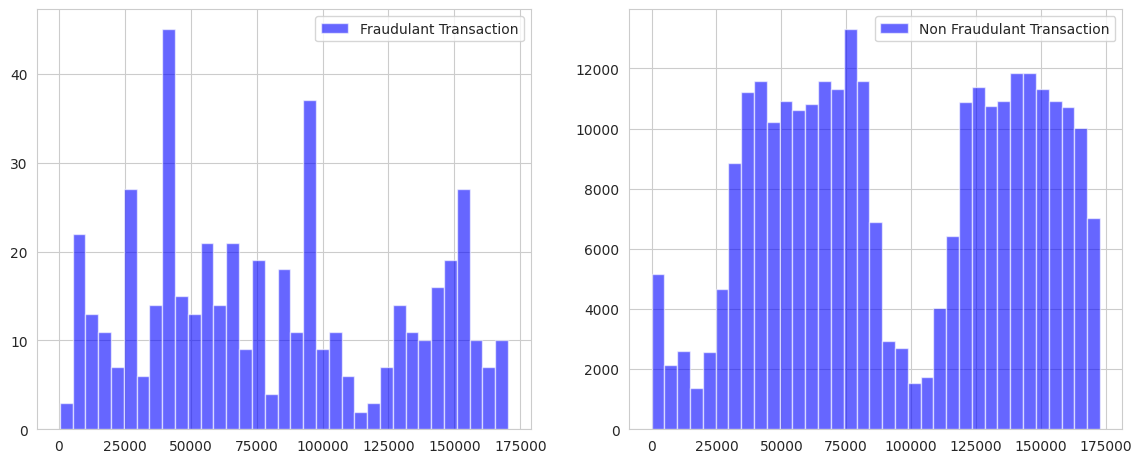

In [13]:
# data[data.Class == 0].Time.hist(bins=35, color='blue', alpha=0.6)
plt.figure(figsize=(14, 12))

plt.subplot(2, 2, 1)
data[data.Class == 1].Time.hist(bins=35, color='blue', alpha=0.6, label="Fraudulant Transaction")
plt.legend()

plt.subplot(2, 2, 2)
data[data.Class == 0].Time.hist(bins=35, color='blue', alpha=0.6, label="Non Fraudulant Transaction")
plt.legend()

By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features. There are techniques that can help the distributions be less skewed which will be implemented in this notebook in the future.

Doesn't seem like the time of transaction really matters here as per above observation.
Now let us take a sample of the dataset for out modelling and prediction

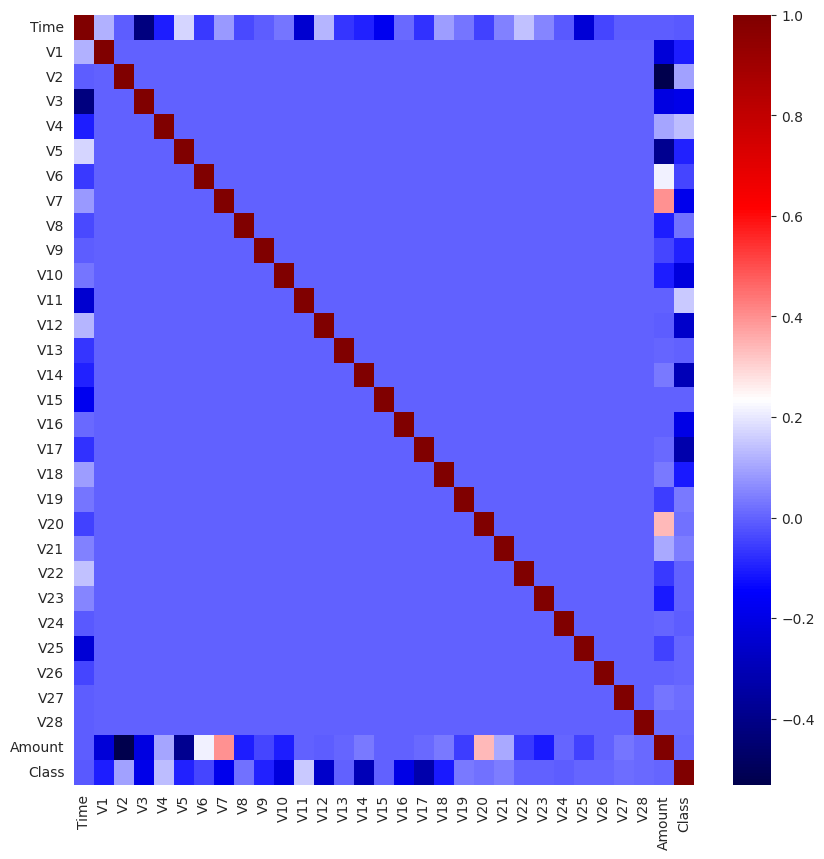

In [14]:
# heatmap to find any high correlations

plt.figure(figsize=(10,10))
sns.heatmap(data=data.corr(), cmap="seismic")
plt.show();

### Highest correlations come from:
    - Time & V3 (-0.42)
    - Amount & V2 (-0.53)
    - Amount & V4 (0.4)

- While these correlations are high, I don't expect it to run the risk of multicollinearity.

- The correlation matrix shows also that none of the V1 to V28 PCA components have any correlation to each other however if we observe Class has some form positive and negative correlations with the V components but has no correlation with Time and Amount.

# 3. Data Pre-processing

`Time` and `Amount` should be scaled as the other columns.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()

X = data.drop('Class', axis=1)
y = data.Class

X_train_v, X_test, y_train_v, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_v, y_train_v,
                                                            test_size=0.2, random_state=42)

X_train = scalar.fit_transform(X_train)
X_validate = scalar.transform(X_validate)
X_test = scalar.transform(X_test)

w_p = y_train.value_counts()[0] / len(y_train)
w_n = y_train.value_counts()[1] / len(y_train)

print(f"Fraudulant transaction weight: {w_n}")
print(f"Non-Fraudulant transaction weight: {w_p}")

Fraudulant transaction weight: 0.0017994745785028623
Non-Fraudulant transaction weight: 0.9982005254214972


In [16]:
print(f"TRAINING: X_train: {X_train.shape}, y_train: {y_train.shape}\n{'_'*55}")
print(f"VALIDATION: X_validate: {X_validate.shape}, y_validate: {y_validate.shape}\n{'_'*50}")
print(f"TESTING: X_test: {X_test.shape}, y_test: {y_test.shape}")

TRAINING: X_train: (159491, 30), y_train: (159491,)
_______________________________________________________
VALIDATION: X_validate: (39873, 30), y_validate: (39873,)
__________________________________________________
TESTING: X_test: (85443, 30), y_test: (85443,)


In [17]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")

    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n")

# 4. Model Building
# 4. 1. Artificial Neural Network (ANNs)

In [18]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[-1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid'),
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │           7,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 142,849 (558.00 KB)

 Trainable params: 141,313 (552.00 KB)

 Non-trainable params: 1,536 (6.00 KB)

In [19]:

METRICS = [
#     keras.metrics.Accuracy(name='accuracy'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

model.compile(optimizer=keras.optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=METRICS)

callbacks = [keras.callbacks.ModelCheckpoint('fraud_model_at_epoch_{epoch}.keras')]
class_weight = {0:w_p, 1:w_n}

r = model.fit(
    X_train, y_train,
    validation_data=(X_validate, y_validate),
    batch_size=2048,
    epochs=50,
#     class_weight=class_weight,
    callbacks=callbacks,
)

Epoch 1/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 13s 103ms/step - fn: 34.7848 - fp: 38478.0742 - loss: 0.8360 - precision: 0.0026 - recall: 0.7161 - tn: 43266.2773 - tp: 108.5316 - val_fn: 12.0000 - val_fp: 536.0000 - val_loss: 0.5749 - val_precision: 0.0961 - val_recall: 0.8261 - val_tn: 39268.0000 - val_tp: 57.0000
Epoch 2/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 6s 81ms/step - fn: 15.4051 - fp: 32141.5957 - loss: 0.7052 - precision: 0.0038 - recall: 0.8898 - tn: 49605.0117 - tp: 125.6582 - val_fn: 13.0000 - val_fp: 119.0000 - val_loss: 0.5096 - val_precision: 0.3200 - val_recall: 0.8116 - val_tn: 39685.0000 - val_tp: 56.0000
Epoch 3/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 12s 102ms/step - fn: 19.3418 - fp: 25586.5059 - loss: 0.6294 - precision: 0.0048 - recall: 0.8647 - tn: 56154.5820 - tp: 127.2405 - val_fn: 13.0000 - val_fp: 70.0000 - val_loss: 0.4476 - val_precision: 0.4444 - val_recall: 0.8116 - val_tn: 39734.0000 - val_tp: 56.0000
Epoch 4/50
78/78 ━━━━━━━━━━━━━━━━━━━━ 9s 82ms/step - fn: 21.3671 - fp: 19122.94

In [20]:
score = model.evaluate(X_test, y_test)
print(score)

2671/2671 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - fn: 14.9667 - fp: 15.9880 - loss: 0.0096 - precision: 0.7980 - recall: 0.7794 - tn: 42681.5742 - tp: 55.4375
[0.008854878135025501, 23.0, 32.0, 85275.0, 113.0, 0.7793103456497192, 0.8308823704719543]


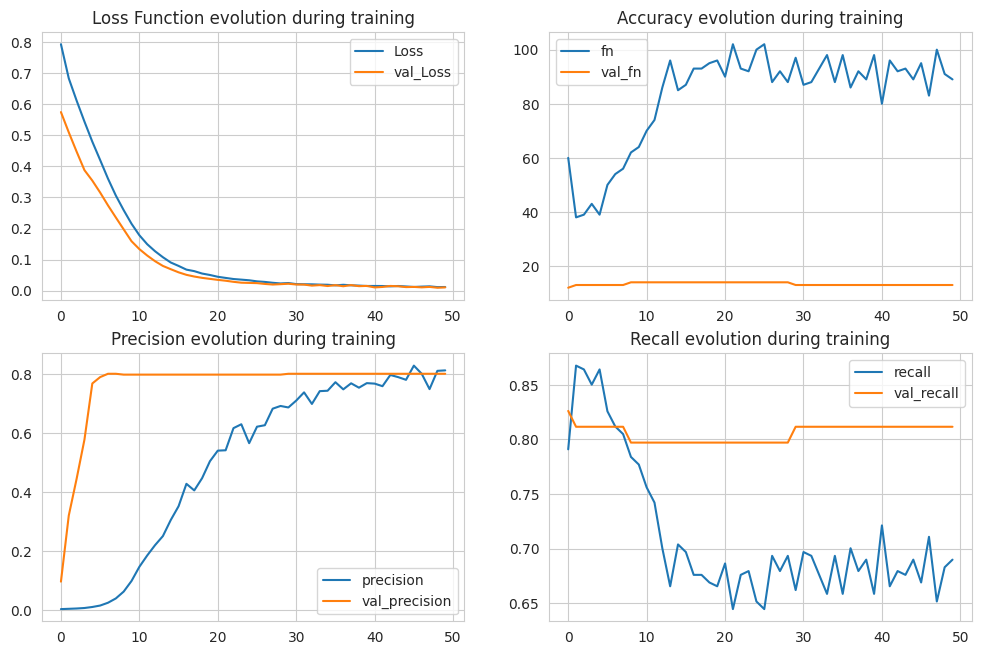

In [21]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function evolution during training')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['fn'], label='fn')
plt.plot(r.history['val_fn'], label='val_fn')
plt.title('Accuracy evolution during training')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision evolution during training')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall evolution during training')
plt.legend()

In [39]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)

scores_dict = {
    'ANNs': {
        'Train': f1_score(y_train, y_train_pred.round()),
        'Test': f1_score(y_test, y_test_pred.round()),
    },
}

4985/4985 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step
2671/2671 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
Train Results:
F1 Score: 0.8248175182481752
Accuracy: 0.9993980851584102
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    159204
           1       0.87      0.79      0.82       287

    accuracy                           1.00    159491
   macro avg       0.93      0.89      0.91    159491
weighted avg       1.00      1.00      1.00    159491

Test Results:
F1 Score: 0.8042704626334519
Accuracy: 0.9993562960102056
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.78      0.83      0.80       136

    accuracy                           1.00     85443
   macro avg       0.89      0.92      0.90     85443
weighted avg       1.00      1.00      1.00     85443



# 4. 2. XGBoost

In [40]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report, accuracy_score

# Instantiate and train the XGBoost classifier
xgb_clf = XGBClassifier(eval_metric='aucpr')  # Specify eval_metric directly in the classifier
xgb_clf.fit(X_train, y_train)

# Predict on training and test data
y_train_pred = xgb_clf.predict(X_train)
y_test_pred = xgb_clf.predict(X_test)

# Define a function to print scores
def print_score(y_true, y_pred, train=True):
    if train:
        print("Train Results:")
    else:
        print("Test Results:")
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

# Print scores for training and test data
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

# Store F1 scores in a dictionary

scores_dict['XGBoost'] = {
    'Train': f1_score(y_train, y_train_pred),
    'Test': f1_score(y_test, y_test_pred),
}

print("Scores dictionary:", scores_dict)


Train Results:
F1 Score: 1.0
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    159204
           1       1.00      1.00      1.00       287

    accuracy                           1.00    159491
   macro avg       1.00      1.00      1.00    159491
weighted avg       1.00      1.00      1.00    159491

Test Results:
F1 Score: 0.8774703557312253
Accuracy: 0.9996371850239341
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.95      0.82      0.88       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443

Scores dictionary: {'ANNs': {'Train': 0.8248175182481752, 'Test': 0.8042704626334519}, 'XGBoost': {'Train': 1.0, 'Test': 0.8774703557312253}}


# 4. 3. Random Forest

In [41]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, oob_score=False)
rf_clf.fit(X_train, y_train)

y_train_pred = rf_clf.predict(X_train)
y_test_pred = rf_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['Random Forest'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

Train Results:
F1 Score: 1.0
Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    159204
           1       1.00      1.00      1.00       287

    accuracy                           1.00    159491
   macro avg       1.00      1.00      1.00    159491
weighted avg       1.00      1.00      1.00    159491

Test Results:
F1 Score: 0.8560311284046692
Accuracy: 0.9995669627705019
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.91      0.81      0.86       136

    accuracy                           1.00     85443
   macro avg       0.95      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



# 4. 4. CatBoost

In [42]:
!pip install catboost

In [43]:
from catboost import CatBoostClassifier

cb_clf = CatBoostClassifier()
cb_clf.fit(X_train, y_train)

Learning rate set to 0.089847
0:	learn: 0.3915001	total: 134ms	remaining: 2m 14s
1:	learn: 0.2368380	total: 249ms	remaining: 2m 4s
2:	learn: 0.1341782	total: 363ms	remaining: 2m
3:	learn: 0.0788507	total: 493ms	remaining: 2m 2s
4:	learn: 0.0482949	total: 642ms	remaining: 2m 7s
5:	learn: 0.0315326	total: 809ms	remaining: 2m 13s
6:	learn: 0.0213628	total: 974ms	remaining: 2m 18s
7:	learn: 0.0153604	total: 1.11s	remaining: 2m 17s
8:	learn: 0.0115137	total: 1.22s	remaining: 2m 13s
9:	learn: 0.0090128	total: 1.32s	remaining: 2m 10s
10:	learn: 0.0071549	total: 1.44s	remaining: 2m 9s
11:	learn: 0.0060639	total: 1.55s	remaining: 2m 7s
12:	learn: 0.0052454	total: 1.65s	remaining: 2m 5s
13:	learn: 0.0046540	total: 1.76s	remaining: 2m 4s
14:	learn: 0.0042228	total: 1.86s	remaining: 2m 2s
15:	learn: 0.0038779	total: 2s	remaining: 2m 3s
16:	learn: 0.0036112	total: 2.13s	remaining: 2m 3s
17:	learn: 0.0034151	total: 2.22s	remaining: 2m
18:	learn: 0.0032510	total: 2.31s	remaining: 1m 59s
19:	learn: 0.

In [44]:
y_train_pred = cb_clf.predict(X_train)
y_test_pred = cb_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['CatBoost'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

Train Results:
F1 Score: 0.9982547993019197
Accuracy: 0.9999937300537335
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    159204
           1       1.00      1.00      1.00       287

    accuracy                           1.00    159491
   macro avg       1.00      1.00      1.00    159491
weighted avg       1.00      1.00      1.00    159491

Test Results:
F1 Score: 0.8705882352941177
Accuracy: 0.9996137776061234
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.93      0.82      0.87       136

    accuracy                           1.00     85443
   macro avg       0.97      0.91      0.94     85443
weighted avg       1.00      1.00      1.00     85443



# 4. 5. LigthGBM

In [45]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier()
lgbm_clf.fit(X_train, y_train)

y_train_pred = lgbm_clf.predict(X_train)
y_test_pred = lgbm_clf.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

scores_dict['LigthGBM'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 287, number of negative: 159204
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.049710 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 159491, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001799 -> initscore=-6.318459
[LightGBM] [Info] Start training from score -6.318459


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Train Results:
F1 Score: 0.3336643495531281
Accuracy: 0.995792866055138
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    159204
           1       0.23      0.59      0.33       287

    accuracy                           1.00    159491
   macro avg       0.62      0.79      0.67    159491
weighted avg       1.00      1.00      1.00    159491

Test Results:
F1 Score: 0.2513089005235602
Accuracy: 0.994979108879604
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.16      0.53      0.25       136

    accuracy                           0.99     85443
   macro avg       0.58      0.76      0.62     85443
weighted avg       1.00      0.99      1.00     85443



# 5. Model Comparaison

<Axes: >

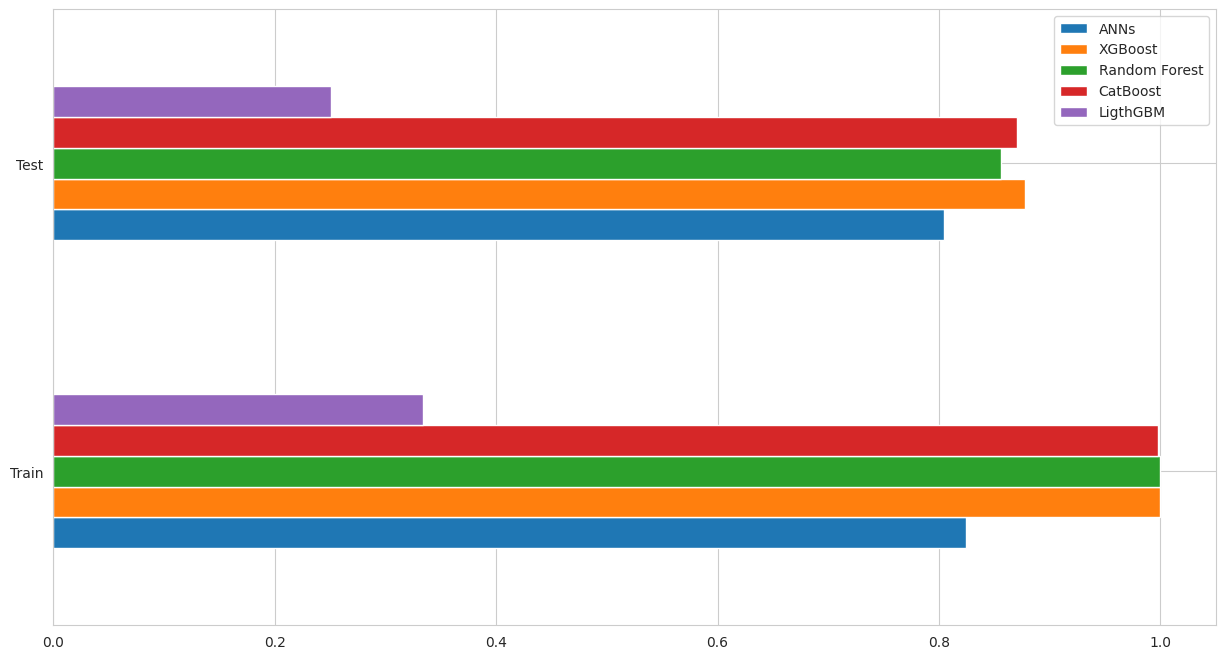

In [46]:
scores_df = pd.DataFrame(scores_dict)

scores_df.plot(kind='barh', figsize=(15, 8))

In [47]:
print(scores_df)

       ANNs  XGBoost  Random Forest  CatBoost  LigthGBM
Train  0.82     1.00           1.00      1.00      0.33
Test   0.80     0.88           0.86      0.87      0.25
